--- 
description: Here we show how to solve clique problem using JijZept and JijModeling.
---

# Clique Problem

Here we show how to solve clique using JijZept and [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/). 
This problem is also mentioned in 2.3. Clique on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Clique Problem?

This is a decision problem of whether or not a clique (complete graph) of size $K$ exists in a given graph.

### Complete graphs

A complete graph is a graph whose two vertices are all adjacent to each other (not including loops or multiple edges).
We show two examples below.

![](./assets/clique_cover_01.png)

As mentioned above, a vertex in a complete graph is adjacent to all other vertices. 
A complete undirected graph $G = (V, E)$ has ${}_V C_2 = \frac{1}{2} V(V-1)$ edges, that is, the number of edges is equal to the number of combinations choosing two vertices from $V$.



## Mathematical Model

First, we introduce binary variables $x_{v}$ which are 1 if vertex $v$ belongs to the subgraph and 0 otherwise.

### Constraint 1: sum of $x_v$ must equal K

In this problem, each vertex $x_v$ either be 1 if vertex $v$ is selected as part of the subgraph, and 0 otherwise.

$$
\sum_{v=0}^{V-1} x_{v} = K \tag{1}
$$

### Constraint 2: the subgraph must be complete

If the subgraph $G (W, E_W)$ where $E_W$ represents the subset of edges $E$ restricted to those connecting nodes within $W$, is complete, then the number of edges in this subgraph is given by $\frac{1}{2} W (W -1)$ from previous discussion. 
Knowing that the subgraph has $\sum_{(uv) \in E_W} x_{u} x_{v}$ edges, we set the constraint function as follows.

$$
 \sum_{(uv) \in E} x_{u} x_{v} = \frac{1}{2} K(K-1) \tag{2}
$$

## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
K = jm.Placeholder('K')
x = jm.BinaryVar('x', shape=(V,))
u = jm.Element('u', (V))
e = jm.Element('e', E)

We use the same variables in the graph partitioning problem, and we add $K$ to that.

### Constraint 1

We implement constraint Equation (1).

In [2]:
# set problem
problem = jm.Problem('Clique')
# set constraint: sum of $x_v$ must equal K
problem += jm.Constraint('constraint1', jm.sum(u, x[u])==K)

### Constraint 2

Next, we implement constraint Equation (2).

In [3]:
# set constraint: the subgraph must be complete
problem += jm.Constraint('constraint2', jm.sum(e, x[e[0]]*x[e[1]])==1/2*K*(K-1))

Let's display the implemented mathematical model in Jupyter Notebook.

In [4]:
problem

## Prepare an instance

We prepare a graph by using [Networkx](https://networkx.org/), focusing on a scenario where the graph includes a complete subgraph of size $K=4$.

In [5]:
import networkx as nx

# set the number of random vertices
inst_V1 = 3
# create a random graph
inst_G1 = nx.gnp_random_graph(inst_V1, 0.2)

# set the size K
inst_K = 4
# create a complete graph with K vertices
inst_G2 = nx.complete_graph(inst_K)

# set the number of vertices
inst_V = inst_V1 + inst_K

# add the complete graph to the given graph
inst_G = nx.union(inst_G1, inst_G2, rename=('G-', 'K-'))

# connect each vertex of G1 to vertex 0 of G2
for i in range(inst_V1):
    inst_G.add_edge(f'G-{i}', 'K-0')

# relabel the nodes using normal numbers from 0
mapping = {node: i for i, node in enumerate(inst_G.nodes)}
inst_G = nx.relabel_nodes(inst_G, mapping)

# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]

instance_data = {'V': inst_V, 'E': inst_E, 'K': inst_K}

This graph for clique problem is shown below.

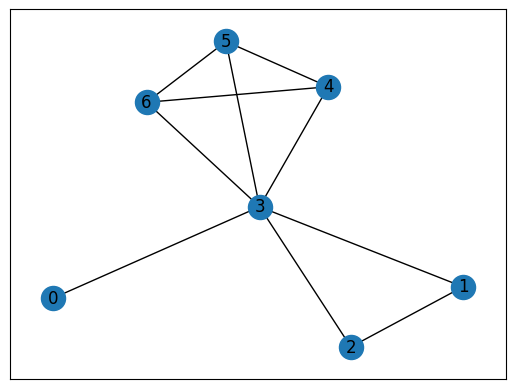

In [6]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(inst_G)
nx.draw_networkx(inst_G, pos, with_labels=True)

plt.show()

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [7]:
import jijzept as jz

# set sampler
config_path = "config.toml"
sampler = jz.JijSASampler(config=config_path)
# solve problem
multipliers = {'constraint1': 0.5, "constraint2": 0.5}
response = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Visualize solution

In the end, we extract the lowest energy solution from the feasible solutions and visualize it.

[5, 4, 3, 6]


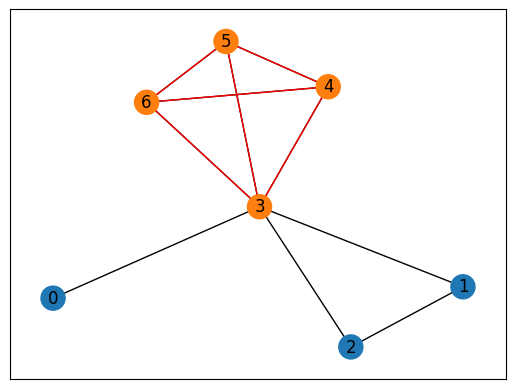

In [8]:
import numpy as np

# get sampleset
sampleset = response.get_sampleset()
# extract feasible samples
feasible_samples = sampleset.feasibles()
# get the solution
solution = feasible_samples[0].var_values["x"].values
# get the vertex numbers
vertices = [key[0] for key in solution]
print(vertices)
# set color list for visualization
cmap = plt.get_cmap("tab10")
# initialize vertex color list
node_colors = [cmap(0)] * instance_data["V"]
# set the vertex color list
for i in vertices:
    node_colors[i] = cmap(1)
# highlight the edge of clique
highlight_edges = [(u, v) for (u, v) in inst_G.edges() if u in vertices and v in vertices]
# make figure
nx.draw_networkx(inst_G, pos, node_color=node_colors, with_labels=True)
nx.draw_networkx_edges(inst_G, pos, edgelist=highlight_edges, edge_color='red')
plt.show()

We obtain a feasible clique as shown above. 

Lastly, we will introduce a trick to reduce the number of extra spins needed to encode a variable that can take $N$ values.
By defining an integer $M$, where $2^M \leq N < 2^{(M+1)}$, $M+1$ binary variables can be used instead of $N$ binary variables.
This can be applied to solve the NP-hard version of the clique problem, and the resulting number of spins required is $N +1+\lfloor \log \Delta \rfloor$, where $\Delta$ represents the maximum degree of the graph being considered in the clique problem.
This is mentioned in 2.4. Reducing $N$ to $log N$ Spins in Some Constraints on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).